# Predicting Categories: Logistic Regression

In previous chapters, we've seen how machine learning models can predict **continuous** variables—like the price of an apartment. However, in many cases, our goal is to predict a **category**, or a discrete value. Predicting categorical outcomes is known as **classification**, and there are various methods to achieve this.

Here, we'll first introduce **logistic regression**, which shares conceptual similarities with linear regression. To understand why logistic regression is preferred, we'll initially attempt to solve a classification problem using linear regression and see why it's unsuitable.

## Data exploration

Here we use a datasets where different types of movements were recorded, resulting in variables indicating acceleration and angular velocity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movement = pd.read_csv(
    "https://raw.githubusercontent.com/digital-sustainability/SAI3-2025/refs/heads/main/datasets/movement.csv"
)

# Randomly sample 10 rows with a fixed seed of 5 for reproducibility
movement.sample(10, random_state=5)

,t,x_acc,y_acc,z_acc,x_rot,y_rot,z_rot,move_type
544,3.436578,21.199216,11.919413,2.630929,-1.293391,-1.313177,6.633328,0
515,3.147962,19.113453,7.374714,-3.551215,1.051330,1.691820,-8.140408,0
193,1.922400,-0.144150,-6.725365,13.823753,-0.374187,-1.334594,-3.837495,1
11,0.111130,3.112029,-0.786614,9.319470,-0.081075,-0.039007,-2.075134,1
279,0.799227,27.152336,-3.675157,-4.966672,-4.022653,-1.860667,10.150594,0
653,4.521375,6.779851,17.095200,4.969216,0.446364,0.970724,4.339361,0
643,4.421852,8.695118,-6.159691,-2.711761,-1.716558,-0.903006,6.270901,0
763,5.616122,6.563701,26.508376,-5.599406,-0.028113,1.726049,-5.227934,0
198,1.972160,0.071402,-6.356382,13.698165,-0.234764,-1.406604,-3.945212,1
721,5.198128,14.704821,7.998617,0.114961,0.427588,2.985066,-7.352628,0


If we perform some exploratory data analysis, we find that the $z$-axis acceleration alone already provides a good distinction between the two types of movements. We'll use this feature as an illustrative example:

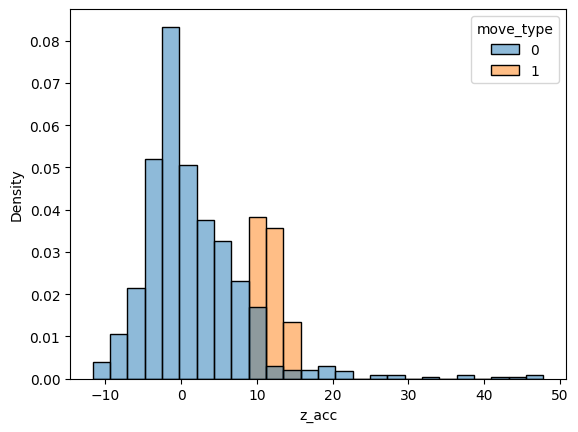

In [3]:
# When we use `stat='density'`, the y-axis is normalized to show a (normalized) density instead of a count
sns.histplot(data=movement, x='z_acc', hue='move_type', stat='density'); 

Note that other features also differ somewhat between the two movement types but aren't as effective for binary classification:

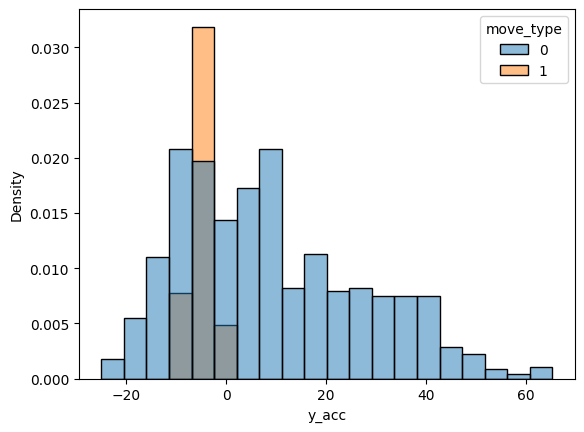

In [4]:
sns.histplot(data=movement, x='y_acc', hue='move_type', stat='density'); 

## Linear Regression

Our goal now is to predict the `move_type` category using the `z_acc` feature. Let's plot this relationship first:

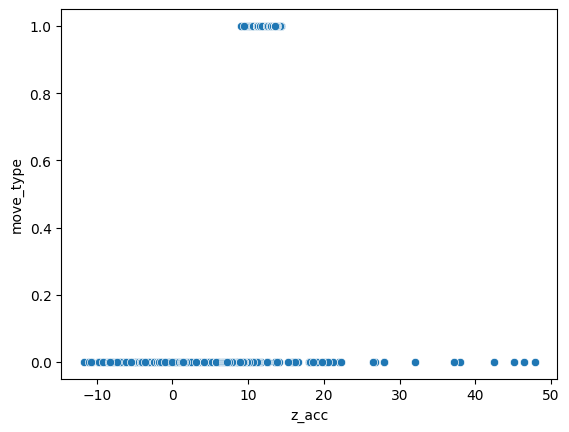

In [5]:
sns.scatterplot(data=movement, x='z_acc', y='move_type');

We can approach this task using the method we've already learned — scikit-learn's `LinearRegression`:

In [6]:
from sklearn import linear_model

In [7]:
lin_model = linear_model.LinearRegression()
lin_model.fit(X=movement[['z_acc']].values, y=movement['move_type'])

z_acc_range = np.arange(-10, 50, 1)
pred = lin_model.predict(z_acc_range[:, np.newaxis])

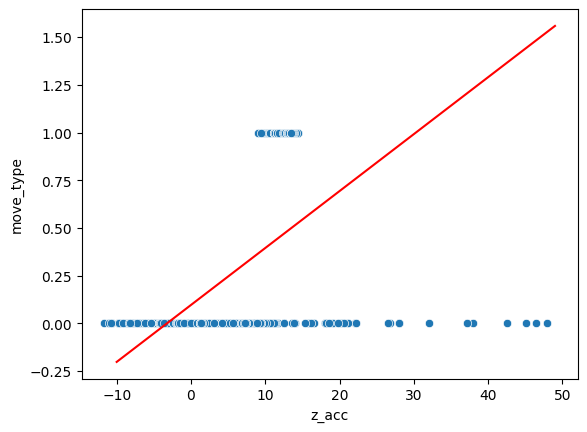

In [8]:
sns.scatterplot(data=movement, x='z_acc', y='move_type')
plt.plot(z_acc_range, pred, 'r');

Clearly, this linear regression model isn't appropriate for classification. While we could set a threshold at 0.5 (predicting class `0` below this value and class `1` above), there would still be significant issues. For instance, data points with extreme feature values disproportionately affect the predictions, leading to large errors.

A more suitable approach is to pass the linear model's output through a **step function**. This step function is defined as follows:

$$
H(x, d) = 
\begin{cases}
0, & \text{if } x < d \\
1, & \text{if } x > d
\end{cases}
$$

Let's manually apply this function to our data:

In [9]:
def step(x, d):
    out = np.zeros(len(x))
    out[x>d] = 1
    return out

In [10]:
# Example of how this function works
print("Input: ", np.arange(1, 10, 1).astype(float))
print("Output:", step(np.arange(1, 10, 1), 5))

Input:  [1. 2. 3. 4. 5. 6. 7. 8. 9.]
Output: [0. 0. 0. 0. 0. 1. 1. 1. 1.]


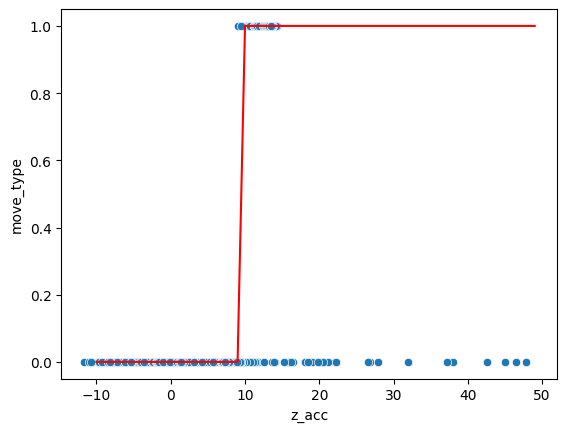

In [11]:
sns.scatterplot(data=movement, x='z_acc', y='move_type')

# Plot a step function with a threshold of 9
plt.plot(np.arange(-10, 50, 1), step(np.arange(-10, 50, 1), 9), 'r');

Right now, we've manually set the threshold at 9. However, we'd prefer our model to automatically determine the optimal threshold. The problem with the step function above is that it's unsuitable for gradient descent, the optimization method we typically use.

Gradient descent works by making small adjustments to parameters and checking whether these changes reduce the error. But with the step function, small adjustments to the parameter `d` usually don't change the outcome, because points rarely switch categories due to tiny parameter shifts. This creates a flat error landscape, leaving gradient descent unable to find a direction to reduce the error.

Thus, we need a smoother function that's differentiable everywhere. A common choice is the **sigmoid** function, which closely resembles the step function but has smooth edges instead. The sigmoid is defined using two parameters: $w$, controlling steepness, and $d$, indicating its location:

$$
\sigma(x; w, d) = \frac{1}{1 + e^{-w(x - d)}}
$$

This smooth transition allows gradient descent to effectively optimize the parameters.

In [12]:
def sigmoid(x, d, w):
    out = 1 / (1 + np.exp(-w*(x-d)))
    return out

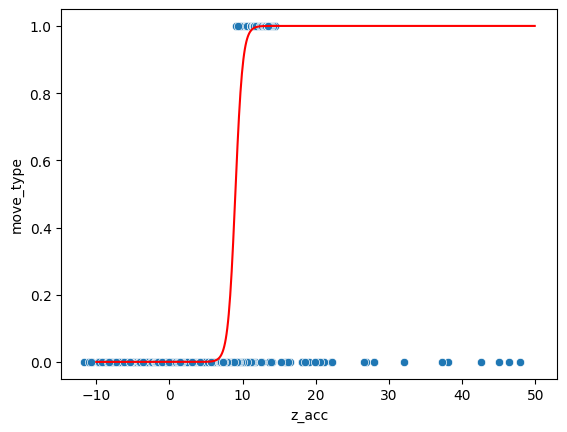

In [13]:
sns.scatterplot(data=movement, x='z_acc', y='move_type');

# Plot a sigmoid function with a "threshold" of 9 and a steepness of 2
plt.plot(np.arange(-10,50,0.1), sigmoid(np.arange(-10,50,0.1), 9, 2), 'r');

We now have a model that gives us smoother predictions. For instance, at an acceleration of `9`, the prediction is exactly $0.5$. This prediction can be interpreted as the **probability** of a point belonging to category `1`. Intuitively, points far to the right have a high probability of belonging to category `1`, while points far to the left are likely to belong to category `0`. A prediction around 0.5 indicates uncertainty.

The difference between the prediction and the true value, such as $\texttt{sigmoid}(x_i; w, d) - y_i$, isn't ideal for gradient descent, because even though the slope isn't zero, it's still very flat and makes optimization slow.

Instead, we typically use a more effective metric for classification tasks: the **cross-entropy loss**, which provides steeper gradients, making optimization more efficient.

## Logistic regression in scikit-learn

Now that we understand why we can't use simple linear regression, let's have a look at how to do logistic regression in scikit-learn. Again we create the model and fit it with our data:

In [14]:
log_model = linear_model.LogisticRegression()
log_model.fit(X=movement[['z_acc']].values, y=movement['move_type'])

LogisticRegression()

Once our model is trained, we can use it to make predictions in two ways:

1. **Probabilities**: We can retrieve the probability of the sample belonging to category `0` or `1` (the output of the sigmoid function).
2. **Predicted Category**: Alternatively, we can directly obtain the predicted class (0 or 1), usually by applying a threshold (often set at 0.5).

Here's how we can get both outputs:


In [15]:
# Create a range of z_acc values from -10 to 50 and format it as a matrix with one value per row
z_acc_values = np.arange(-10, 50, 0.1).reshape(-1, 1)

pred_prob = log_model.predict_proba(z_acc_values)
pred = log_model.predict(z_acc_values)

print("Shape of pred_prob:", pred_prob.shape)

Shape of pred_prob: (600, 2)


In [16]:
pred_prob[-5:]

array([[3.10572908e-05, 9.99968943e-01],
       [3.02229651e-05, 9.99969777e-01],
       [2.94110522e-05, 9.99970589e-01],
       [2.86209500e-05, 9.99971379e-01],
       [2.78520726e-05, 9.99972148e-01]])

In [17]:
pred[-5:]

array([1, 1, 1, 1, 1])

We observe that our prediction (`pred_proba`) returns an array with shape `(600, 2)`. Each of the 600 rows corresponds to one sample. The two columns represent probabilities for each class:

- **Column 1** contains the probability that the sample belongs to category `0`.
- **Column 2** gives the probability for the second category, corresponding to a `move_type` of `1`.

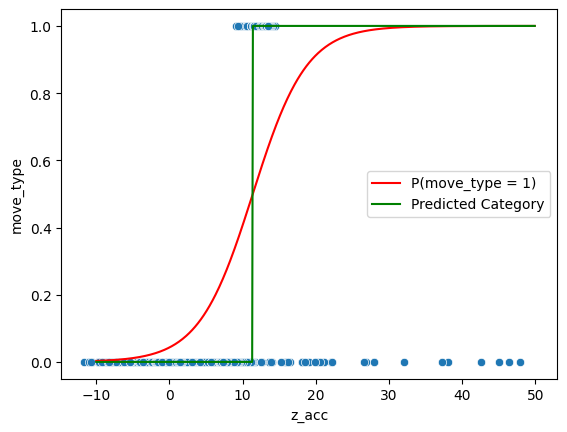

In [18]:
ax = sns.scatterplot(data=movement, x='z_acc', y='move_type')

# Plot the probability of the positive class (1)
ax.plot(z_acc_values.flatten(), pred_prob[:, 1], 'r', label='P(move_type = 1)')

# Plot the predicted class
ax.plot(z_acc_values.flatten(), pred, 'g', label='Predicted Category')
ax.legend();

## Estimating the Error

We used **cross-entropy loss** during training, as it's a smooth, differentiable metric ideal for gradient descent optimization. However, cross-entropy values can be difficult to interpret intuitively.

To better understand our model's accuracy, let's directly compare our predictions with the true labels. Below, we calculate the difference between the actual `move_type` and our predictions:

In [19]:
predict_data = log_model.predict(movement[['z_acc']].values)

movement['move_type'] - predict_data

0       1
1       1
2       1
3       1
4       1
       ..
996     0
997     0
998     0
999     0
1000    0
Name: move_type, Length: 1001, dtype: int64

Whenever the difference is `0`, the prediction was accurate; whenever we see a `-1` or `1`, we've misclassified that data point:

| `movement['move_type']` | `predict_data` | difference |
|--------|--------|------------|
| 0      | 0      | 0          |
| 0      | 1      | -1         |
| 1      | 0      | 1          |
| 1      | 1      | 0          |

Let's first count how many predictions were incorrect. We'll use the absolute value to treat `-1` as a misclassification as well. Then we'll compute the misclassification rate as a percentage of all predictions:

In [20]:
tmp = np.arange(5)
tmp

array([0, 1, 2, 3, 4])

In [21]:
tmp >= 3

array([False, False, False,  True,  True])

In [22]:
(tmp >= 3).astype(int)

array([0, 0, 0, 1, 1])

In [23]:
np.sum(tmp >= 3)

np.int64(2)

In [24]:
# Let the model predict the move_type based on the z_acc values
predicted_move_types = log_model.predict(movement[['z_acc']].values)

# The resulting array contains the difference between the actual move_type and the predicted move_type
wrong_predictions = np.abs(movement['move_type'] - predicted_move_types)

# Calculate the error rate by dividing the number of wrong predictions by the total number of samples
error_rate = wrong_predictions.sum() / len(movement)

# Print the error rate
print("Error rate:", error_rate)

# Print the percentage of incorrect predictions
print(f"{error_rate:.2%} of the samples were classified incorrectly.")

Error rate: 0.13986013986013987
13.99% of the samples were classified incorrectly.


And correctly classified:

In [25]:
num_correctly_predicted = np.sum((movement['move_type'] - predicted_move_types) == 0) / len(movement)
print(f"{num_correctly_predicted:.2%} of the samples were classified correctly.")

# Or easier:
print(f"{1 - error_rate:.2%} of the samples were classified correctly.")

86.01% of the samples were classified correctly.
86.01% of the samples were classified correctly.


So we have an accuracy of 86%. This seems quite good, but is it as good as it seems?

## Checking Model Quality

Now, instead of calculating the overall accuracy, let's check how well our model performs for each category individually. In other words, we want to assess how accurately the model predicts each movement type separately.

We can do this by selecting predictions corresponding to each category and then counting how many times the model predicted correctly for each:

In [26]:
movement["move_type"] == 0

0       False
1       False
2       False
3       False
4       False
        ...  
996      True
997      True
998      True
999      True
1000     True
Name: move_type, Length: 1001, dtype: bool

In [27]:
# Indicates whether the move type is 0 or not for each sample
is_move_type_0 = movement['move_type'] == 0

# Use the indicator array above to select only the samples where the (target) move type is 0 (let's call this the negative class)
predictions_on_samples_with_actual_move_type_0 = predicted_move_types[is_move_type_0]

# Count the number of samples where the prediction is 0 (true negatives)
num_true_negatives = np.sum(predictions_on_samples_with_actual_move_type_0 == 0)

print("Number of true negatives:", num_true_negatives)

# Or in one line:
print("Number of true negatives:", np.sum(predicted_move_types[movement['move_type'] == 0] == 0))

Number of true negatives: 763
Number of true negatives: 763


or as a fraction:

In [28]:
num_negative_samples = is_move_type_0.sum()

print(f"True Negative Rate: {num_true_negatives / num_negative_samples:.2%}")

True Negative Rate: 95.38%


Here, we've correctly predicted the movement "running" (category 0) 95% of the time. Let's now examine how well our model's is able to detect the "rotation" (category 1) movement in comparison:

In [29]:
# Indicates whether the move type is 1 or not for each sample
is_move_type_1 = movement['move_type'] == 1

# Let's call move_type = 1 the positive class
actual_positives = movement[is_move_type_1]
true_positives = predicted_move_types[(predicted_move_types == 1) & is_move_type_1]  # Predicted 1 and actual 1

true_positive_rate = len(true_positives) / len(actual_positives)

print(f"True Positive Rate (Recall): {true_positive_rate:.2%}")

True Positive Rate (Recall): 48.76%


We see that our model correctly predicts only 48% of the "rotation" movements.

Instead of manually calculating "accuracy" for each category, we can use scikit-learn's **confusion matrix**. This matrix conveniently summarizes how many predictions were correct or incorrect for each category. To use it, we simply provide the actual and predicted values:

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
confusion_matrix(movement["move_type"], predicted_move_types)

array([[763,  37],
       [103,  98]])

The confusion matrix displays the same results we calculated previously. The values `98` and `763` represent correctly classified movements, while `37` and `103` indicate misclassifications.

Each entry in the confusion matrix has standard terminology. If we now define predicting **"rotation"** as the **positive** outcome and **"running"** as the **negative** outcome, we have:

- Correctly classifying an actual **"rotation"** movement as **"rotation"** is a **True Positive (TP)**.
- Incorrectly classifying a **"rotation"** movement as **"running"** is a **False Negative (FN)**.
- Correctly classifying a **"running"** movement as **"running"** is a **True Negative (TN)**.
- Incorrectly classifying a **"running"** movement as **"rotation"** is a **False Positive (FP)**.

These four scenarios are summarized visually in the figure below:

![Confusion Matrix](https://github.com/digital-sustainability/SAI3-2025/blob/main/illustrations/confusion_matrix.png?raw=true)

The accuracy (number of correctly predicted samples) we previously calculated can now easily be derived from the confusion matrix by summing the diagonal values (the correctly predicted outcomes) and dividing by the total number of data points:

$$
\text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

In a later section, we'll introduce more sophisticated metrics based on combinations of these four terms. For now, let's focus on improving our model.


## Imbalance

Why does our model perform well on one type of movement but poorly on the other? The main reason is that the dataset is heavily **imbalanced**, meaning one category is significantly more common than the other:

In [32]:
f'Number of "running": {len(movement[movement["move_type"]==0])}'

'Number of "running": 800'

In [33]:
f'Number of "rotation": {len(movement[movement["move_type"]==1])}'

'Number of "rotation": 201'

Imagine if we had even fewer examples of the "rotation" movement — for instance, just two samples. In such a scenario, a naive model that **always** predicts "running" would achieve 99% accuracy effortlessly. This clearly isn't desirable!

In situations like this, we need to explicitly inform our ML model to pay special attention to rare categories. We achieve this by assigning different **weights** to each category during the learning process.

A common solution is to set these weights inversely proportional to the frequency of each category — e.g., `1/800` for one category and `1/201` for the other. For logistic regression in scikit-learn, this is done by providing a list of per-sample weights. We can easily achieve this by adding a weight column to our dataset:

In [34]:
# Easier way to get the number of samples per class
num_samples_per_class = movement["move_type"].value_counts()
num_samples_per_class

move_type
0    800
1    201
Name: count, dtype: int64

In [35]:
# Calculate the weights for each class
weights = 1/num_samples_per_class
weights

move_type
0    0.001250
1    0.004975
Name: count, dtype: float64

In [36]:
# Create e new column called 'weight' and set it to 1 initially for all samples
movement['weight'] = 1.0

# Set the weight to the corresponding value for each class. Whenever you filter and set values in pandas at the same time, you should use .loc
movement.loc[movement['move_type']==0, 'weight'] = weights[0]
movement.loc[movement['move_type']==1, 'weight'] = weights[1]

In [37]:
movement.sample(10)

,t,x_acc,y_acc,z_acc,x_rot,y_rot,z_rot,move_type,weight
331,1.316745,0.271685,-8.025860,-1.365311,-1.026898,-2.205949,11.426162,0,0.001250
171,1.703455,0.951571,-7.793394,11.599080,-0.456668,-1.297079,-4.119938,1,0.004975
497,2.968822,18.819165,40.847807,9.810449,-0.756795,1.008539,1.537852,0,0.001250
794,5.924642,8.752599,31.242431,1.714535,-1.831377,1.440379,6.929235,0,0.001250
533,3.327103,-6.498436,-8.262817,4.158353,-0.039497,-1.905681,5.092955,0,0.001250
404,2.043261,8.058792,25.050856,-2.208358,0.468117,2.031907,-5.242518,0,0.001250
319,1.197318,6.275849,-14.836697,-2.505639,2.333175,0.292909,-3.357194,0,0.001250
717,5.158319,13.129946,8.040979,-2.157164,1.051109,2.518859,-7.007245,0,0.001250
47,0.469403,2.706671,-5.214107,10.487042,-0.078141,-0.538502,-3.369242,1,0.004975
738,5.367317,1.761537,-8.858728,4.171076,1.586236,-1.746621,6.998374,0,0.001250


Let's tell our model to use these weights when fitting the parameters to the data:

In [38]:
log_model = linear_model.LogisticRegression()
log_model.fit(X=movement[['z_acc']].values, y=movement['move_type'].values, sample_weight=movement['weight'].values)

LogisticRegression()

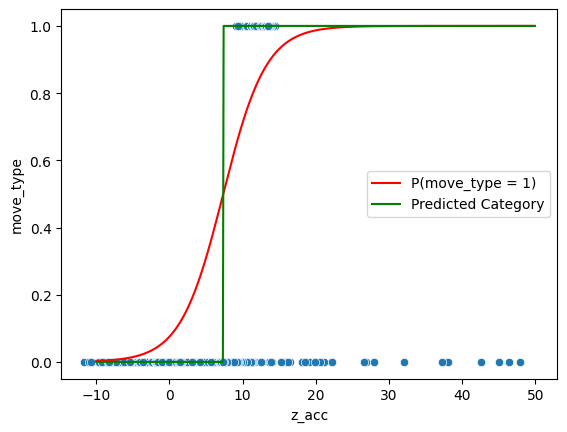

In [39]:
pred_prob = log_model.predict_proba(np.arange(-10,50,0.1)[:, np.newaxis])
pred = log_model.predict(np.arange(-10,50,0.1)[:, np.newaxis])

ax = sns.scatterplot(data=movement, x='z_acc', y='move_type')

# Plot the probability of the positive class (1)
ax.plot(z_acc_values.flatten(), pred_prob[:, 1], "r", label="P(move_type = 1)")

# Plot the predicted class
ax.plot(z_acc_values.flatten(), pred, "g", label="Predicted Category")
ax.legend();

In [40]:
predicted_move_types = log_model.predict(movement[["z_acc"]].values)

confusion_matrix(movement["move_type"], predicted_move_types)

array([[690, 110],
       [  0, 201]])

In [41]:
actual_negatives = movement[movement["move_type"] == 0]
true_negatives = predicted_move_types[(predicted_move_types == 0) & (movement["move_type"] == 0)]

true_negative_rate = len(true_negatives) / len(actual_negatives)

print(f"True negative rate: {true_negative_rate:.2%}")

True negative rate: 86.25%


In [42]:
actual_positives = movement[movement["move_type"] == 1]
true_positives = predicted_move_types[(predicted_move_types == 1) & (movement["move_type"] == 1)]

true_positive_rate = len(true_positives) / len(actual_positives)

print(f"True positive rate (Recall): {true_positive_rate:.2%}")

True positive rate (Recall): 100.00%


We observe that by using these sample weights, we significantly improved the model’s ability to correctly identify the positive ("rotation") cases, with only a minor reduction in correctly classifying negative ("running") cases.

Assigning different weights is a common and effective practice across many machine learning methods, including deep learning. For example, when building a fraud-detection model, fraudulent transactions are usually very rare compared to legitimate ones. In such cases, assigning a higher weight to fraudulent examples ensures that the model pays greater attention to these rare — but crucial — instances during training.

## Other Metrics

Previously, we introduced the concepts of True/False Positives and Negatives (TP, FP, TN, FN) and used them to define evaluation metrics such as **accuracy**:

$$
\text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

However, there are other important metrics commonly used in machine learning to evaluate model quality, notably **precision** and **recall**.

- **Precision** measures how precise our predictions are: it tells us the proportion of predicted positives that are actually correct. Formally, it's defined as:

$$
\text{precision} = \frac{TP}{TP + FP}
$$

- **Recall** measures how effectively the model identifies positives: it tells us the fraction of actual positives that are correctly predicted. Formally:

$$
\text{recall} = \frac{TP}{TP + FN}
$$

Ideally, we want both high precision and high recall. A high precision means our model rarely predicts positives incorrectly (low FP). However, precision alone doesn't guarantee good performance, because it ignores how many true positives we might have missed. Similarly, recall tells us if we're correctly identifying most positives, with few false negatives.

Let's illustrate these concepts with a simple example, where we classify images as either "cat" or "dog". Let's see how good our model performs on detecting cats, i.e. we choose "cat" as the positive and "dog" as the negative class. We train two different models and obtain the following results:

![Confusion Matrix for Cat/Dog Classification](https://raw.githubusercontent.com/digital-sustainability/SAI3-2025/refs/heads/main/illustrations/confusion_matrix_cat_dog.png)

We see in this example that both models (left and right) have the same **precision**:

$$
\text{precision} = \frac{5}{5 + 1} = 0.83
$$

This means that whenever our model predicts "cat," it's usually correct, and we rarely misclassify dogs as cats (low false positives).

However, let's consider the **recall**:

- On the left side, we have:
$$
\text{recall} = \frac{5}{5 + 10} = 0.33
$$
This is poor—we're missing many actual cat images. Although our positive predictions (cats) are usually correct, we fail to identify most cats.

- On the right side, the recall is much better:
$$
\text{recall} = \frac{5}{5 + 1} = 0.83
$$
Here, we're correctly identifying most of the cats.

To combine precision and recall into a single metric, we commonly use the **F-score** (or F1-score), defined as the harmonic mean of precision and recall:

$$
F = 2 \cdot \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$

In our examples above, we get:
- Left: $F = 0.47$ (poor)
- Right: $F = 0.83$ (good)

Depending on the problem, we might prioritize **precision** or **recall** differently.

For example, imagine a system that detects **defective parts in a factory**. Ideally, we want both high precision and high recall:
- High **recall** ensures we catch *all* defective parts — we don’t let bad products reach customers.
- High **precision** ensures that when the system flags a part as defective, it *really is* defective — so we don’t waste time or money checking perfectly fine items.

Now consider a **medical screening test**, such as one for detecting a serious disease. In this case, **high recall** becomes more important: we want to identify as many affected patients as possible, even if it means some healthy people get false positives. Missing someone who actually has the disease (a false negative) could have severe consequences.

So depending on the context:
- If **missing a positive case is costly or dangerous**, we prioritize **recall** (as in medical diagnostics).
- If **raising a false alarm is costly or disruptive**, we prioritize **precision**.

## Metrics in scikit-learn

We get access to all these metrics via scikit-learn. There are specific functions like ```precision_socre``` but we can also get a summary of all values with either ```precision_recall_fscore_support``` or ```classification_report```.

In [43]:
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_fscore_support, classification_report

First we redo our classification, once with and once without class weights:

In [44]:
log_model_noweight = linear_model.LogisticRegression()
log_model_noweight.fit(X=movement[['z_acc']], y=movement['move_type'])

log_model_weight = linear_model.LogisticRegression()
log_model_weight.fit(X=movement[['z_acc']], y=movement['move_type'], sample_weight=movement['weight']);

predict_data_noweigth = log_model_noweight.predict(movement[['z_acc']])
predict_data_weigth = log_model_weight.predict(movement[['z_acc']])

Now we compute can look at the reports:

In [45]:
print(classification_report(movement['move_type'], predict_data_weigth))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93       800
           1       0.65      1.00      0.79       201

    accuracy                           0.89      1001
   macro avg       0.82      0.93      0.86      1001
weighted avg       0.93      0.89      0.90      1001



In [46]:
print(classification_report(movement['move_type'], predict_data_noweigth))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92       800
           1       0.73      0.49      0.58       201

    accuracy                           0.86      1001
   macro avg       0.80      0.72      0.75      1001
weighted avg       0.85      0.86      0.85      1001



We see that the model provides scores for each category. Depending on the task, we might be interested in evaluating individual categories or looking at overall performance.

- In **binary classification** (e.g., sick vs. not sick), it's often enough to look at the metrics for one class (usually the positive class).
- In **multi-class classification** (e.g., cats, dogs, rabbits), we typically want to assess performance across all categories.

In such cases, we can use **average scores** such as the `f1-score`, which summarizes both precision and recall for each class. These scores can be averaged in different ways — for instance, the **macro average** treats all classes equally, while **weighted averages** give more importance to frequent classes.

In the example above, we see that the **macro average F1-score improves when using class weights**, helping the model better handle imbalanced datasets.

## Exercise

1. Import the `housing.csv` dataset from the dataset directory. The ```good_bad``` feature is an "artifical" binary feature indicating if the house is nice or not. **Note** that this is not exactly the same dataset as `kc_house_data.csv`!

2. Use logistic regression to predict the ```good_bad``` feature with ```sqft_living```

3. Find the accuracy of your model.

4. Print a report of the scores of the classification